In [ ]:
import json
import sys
import subprocess
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

In [ ]:
from transformers import AutoTokenizer, PreTrainedTokenizerFast

In [ ]:
def default_chunk_params_for_model(model_name: str) -> Tuple[int, int]:
    mn = model_name.lower()
    if "mpnet" in mn:
        return 320, 48
    return 384, 64

In [ ]:
@dataclass(frozen=True)
class ChunkConfig:
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    max_len: int = 512
    target_size: Optional[int] = None
    overlap: Optional[int] = None
    min_tokens: int = 10
    max_windows_per_section: int = 4
    add_section_title: bool = True
    make_mini_enunciado: bool = False
    mini_size: int = 128
    keep_header_once: bool = True

In [ ]:
@dataclass(frozen=True)
class ChunkRecord:
    id: str
    number: str
    section: str
    text: str
    token_start: int
    token_end: int
    token_count: int
    char_start: int
    char_end: int
    metadata: Dict[str, Optional[str]]

In [ ]:
_TOKENIZER_CACHE = {}

def load_tokenizer(model_name: str):
    if model_name in _TOKENIZER_CACHE:
        return _TOKENIZER_CACHE[model_name]
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if not isinstance(tok, PreTrainedTokenizerFast):
        raise RuntimeError("A fast tokenizer is required (use_fast=True) for offset mapping.")
    _TOKENIZER_CACHE[model_name] = tok
    return tok


In [ ]:
def resolve_sizes(cfg: ChunkConfig) -> Tuple[int, int]:
    if cfg.target_size is not None and cfg.overlap is not None:
        return cfg.target_size, cfg.overlap
    ts, ov = default_chunk_params_for_model(cfg.model_name)
    ts = cfg.target_size if cfg.target_size is not None else ts
    ov = cfg.overlap if cfg.overlap is not None else ov
    return ts, ov

In [ ]:
def tokenize_with_offsets(tokenizer, text: str) -> Tuple[List[int], List[Tuple[int, int]]]:
    enc = tokenizer(
        text,
        add_special_tokens=False,
        return_offsets_mapping=True,
        truncation=False,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    input_ids: List[int] = enc["input_ids"]
    offsets: List[Tuple[int, int]] = [(int(a), int(b)) for a, b in enc["offset_mapping"]]
    return input_ids, offsets


In [ ]:
def detokenize_span(text: str, offsets: List[Tuple[int, int]], start: int, end: int) -> Tuple[str, int, int]:
    if end <= 0 or start >= len(offsets):
        return "", 0, 0
    start = max(0, start)
    end = min(len(offsets), end)
    if start >= end:
        return "", 0, 0
    char_start = offsets[start][0]
    char_end = offsets[end - 1][1]
    return text[char_start:char_end], char_start, char_end

In [ ]:
def make_windows(n_tokens: int, size: int, overlap: int) -> List[Tuple[int, int]]:
    if n_tokens <= 0:
        return []
    if size <= 0:
        return [(0, n_tokens)]
    if n_tokens <= size:
        return [(0, n_tokens)]
    stride = max(1, size - overlap)
    out = []
    start = 0
    while start < n_tokens:
        end = min(n_tokens, start + size)
        out.append((start, end))
        if end == n_tokens:
            break
        start += stride
    return out

In [ ]:
def build_sections(record: Dict[str, Optional[str]]) -> List[Tuple[str, str]]:
    number = (record.get("number") or "").strip()
    topic = (record.get("topic") or "").strip()
    enunciado = (record.get("enunciado") or "").strip()
    refs = (record.get("referencias_legislativas") or "").strip()
    orgao = (record.get("orgao_julgador") or "").strip()
    data = (record.get("data_decisao") or "").strip()
    fonte = (record.get("fonte") or "").strip()
    excertos = (record.get("excertos_precedentes") or "").strip()

    header_lines = []
    if number:
        header_lines.append(f"SÚMULA {number}")
    if topic:
        header_lines.append(topic)
    header_text = "\n".join([ln for ln in header_lines if ln])

    orgao_data_fonte_lines = []
    if orgao:
        orgao_data_fonte_lines.append(f"Órgão Julgador: {orgao}")
    if data:
        orgao_data_fonte_lines.append(f"Data da decisão: {data}")
    if fonte:
        orgao_data_fonte_lines.append(f"Fonte: {fonte}")
    orgao_data_fonte_text = "\n".join(orgao_data_fonte_lines)

    sections: List[Tuple[str, str]] = []
    if header_text:
        sections.append(("header", header_text))
    if enunciado:
        sections.append(("enunciado", f"Enunciado:\n{enunciado}"))
    if refs:
        sections.append(("referencias_legislativas", f"Referências Legislativas:\n{refs}"))
    if orgao_data_fonte_text:
        sections.append(("orgao_data_fonte", orgao_data_fonte_text))
    if excertos:
        sections.append(("excertos_precedentes", f"Excerto dos Precedentes Originários:\n{excertos}"))
    return sections

In [ ]:
def section_title(number: str, section: str) -> str:
    mapping = {
        "header": "HEADER",
        "enunciado": "ENUNCIADO",
        "referencias_legislativas": "REFERÊNCIAS LEGISLATIVAS",
        "orgao_data_fonte": "ÓRGÃO/DATA/FONTE",
        "excertos_precedentes": "EXCERTOS DOS PRECEDENTES",
        "enunciado_mini": "ENUNCIADO (MINI)",
    }
    label = mapping.get(section, section.upper())
    return f"SÚMULA {number} — {label}"

In [ ]:
def chunk_section(
    tokenizer,
    number: str,
    section_name: str,
    section_text: str,
    cfg: ChunkConfig,
) -> List[ChunkRecord]:
    target_size, overlap = resolve_sizes(cfg)
    input_ids, offsets = tokenize_with_offsets(tokenizer, section_text)
    n = len(input_ids)
    if n == 0:
        return []

    windows = make_windows(n, target_size, overlap)
    if section_name == "enunciado" and n <= cfg.max_len:
        windows = [(0, n)]

    if len(windows) > cfg.max_windows_per_section:
        windows = windows[:cfg.max_windows_per_section]

    out: List[ChunkRecord] = []
    for (ws, we) in windows:
        text_slice, char_start, char_end = detokenize_span(section_text, offsets, ws, we)
        if not text_slice:
            continue

        chunk_text = text_slice.strip()
        if cfg.add_section_title:
            chunk_text = f"{section_title(number, section_name)}\n{chunk_text}".strip()

        token_count = we - ws
        if token_count < cfg.min_tokens:
            continue

        cid = f"{number}#{section_name}@{ws}-{we}" if (we - ws) != n else f"{number}#{section_name}"
        out.append(
            ChunkRecord(
                id=cid,
                number=number,
                section=section_name,
                text=chunk_text,
                token_start=ws,
                token_end=we,
                token_count=token_count,
                char_start=char_start,
                char_end=char_end,
                metadata={},
            )
        )
    return out

In [ ]:
def chunk_record(
    tokenizer,
    record: Dict[str, Optional[str]],
    cfg: ChunkConfig,
) -> List[ChunkRecord]:
    number = str(record.get("number") or "").strip()
    if not number:
        return []

    base_meta = {
        "number": record.get("number"),
        "topic": record.get("topic"),
        "enunciado": record.get("enunciado"),
        "referencias_legislativas": record.get("referencias_legislativas"),
        "orgao_julgador": record.get("orgao_julgador"),
        "data_decisao": record.get("data_decisao"),
        "fonte": record.get("fonte"),
        "excertos_precedentes": record.get("excertos_precedentes"),
    }

    sections = build_sections(record)

    chunks: List[ChunkRecord] = []
    header_emitted = False

    for section_name, section_text in sections:
        if section_name == "header" and cfg.keep_header_once and header_emitted:
            continue

        partial = chunk_section(tokenizer, number, section_name, section_text, cfg)
        for c in partial:
            c.metadata.update(base_meta)
        chunks.extend(partial)

        if section_name == "header":
            header_emitted = True
    if cfg.make_mini_enunciado:
        enun = (record.get("enunciado") or "").strip()
        if enun:
            ids, offsets = tokenize_with_offsets(tokenizer, enun)
            if len(ids) > 0:
                end = min(len(ids), cfg.mini_size)
                text_slice, c0, c1 = detokenize_span(enun, offsets, 0, end)
                if text_slice:
                    text = text_slice.strip()
                    if cfg.add_section_title:
                        text = f"{section_title(number, 'enunciado_mini')}\n{text}".strip()
                    mini = ChunkRecord(
                        id=f"{number}#enunciado_mini@0-{end}",
                        number=number,
                        section="enunciado_mini",
                        text=text,
                        token_start=0,
                        token_end=end,
                        token_count=end,
                        char_start=c0,
                        char_end=c1,
                        metadata=base_meta.copy(),
                    )
                    if mini.token_count >= cfg.min_tokens:
                        chunks.append(mini)

    return chunks

In [ ]:
def read_sumulas_json(path: str) -> List[Dict[str, Optional[str]]]:
    data = json.loads(Path(path).read_text(encoding="utf-8"))
    if not isinstance(data, list):
        raise ValueError("Input JSON must be a list of records.")
    return data

In [ ]:
def write_jsonl(path: str, records: Iterable[Dict]) -> None:
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open("w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

In [ ]:
def run_chunking(
    input_json: str,
    output_jsonl: str,
    config: Optional[ChunkConfig] = None
) -> int:
    cfg = config or ChunkConfig()
    tokenizer = load_tokenizer(cfg.model_name)
    sumulas = read_sumulas_json(input_json)

    total = 0
    with Path(output_jsonl).open("w", encoding="utf-8") as out:
        for rec in sumulas:
            chunks = chunk_record(tokenizer, rec, cfg)
            for ch in chunks:
                out.write(json.dumps(asdict(ch), ensure_ascii=False) + "\n")
                total += 1
    print(f"Wrote {total} chunks → {output_jsonl}")
    return total

In [ ]:
chunks = run_chunking(
    input_json="/content/sumulas_stj_clean.json",
    output_jsonl="/content/sumulas_chunks_mpnet.jsonl",
    config=ChunkConfig(
        model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        make_mini_enunciado=True,
        max_windows_per_section=4
    )
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1182 > 512). Running this sequence through the model will result in indexing errors


Wrote 5764 chunks → /content/sumulas_chunks_mpnet.jsonl


In [ ]:
from transformers import AutoTokenizer

MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

mx = 0; bad = None
cnt = 0
with open("/content/sumulas_chunks_mpnet.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        c = json.loads(line)
        n = len(tok.encode(c["text"], add_special_tokens=False, truncation=False))
        mx = max(mx, n); cnt += 1
        if n == mx: bad = c["id"]
print("Max tokens in a chunk:", mx, "example id:", bad, "over", cnt, "chunks")

Max tokens in a chunk: 335 example id: 676#excertos_precedentes@544-864 over 5764 chunks


In [ ]:
import os, sys, json, subprocess, random, math
from pathlib import Path
from typing import List, Dict, Optional
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
CHUNKS_JSONL = "/content/sumulas_chunks_mpnet.jsonl"
MODEL_NAME   = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
BATCH_SIZE   = 64
MAX_SEQ_LEN  = 384
SEED         = 42
PCA_DIM      = 50
TSNE_PERP    = 30
TSNE_N_ITER  = 1000
MAX_POINTS   = 6000

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
def load_chunks(jsonl_path: str) -> List[Dict]:
    rows = []
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

chunks = load_chunks(CHUNKS_JSONL)
print(f"Loaded {len(chunks)} chunks")

idx = np.arange(len(chunks))
if MAX_POINTS and len(chunks) > MAX_POINTS:
    idx = np.random.RandomState(SEED).choice(len(chunks), size=MAX_POINTS, replace=False)
    chunks = [chunks[i] for i in idx]
    print(f"Sampled down to {len(chunks)} chunks for t-SNE")

texts   = [c["text"] for c in chunks]
ids     = [c["id"] for c in chunks]
sections= [c["section"] for c in chunks]
numbers = [c["number"] for c in chunks]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(MODEL_NAME, device=device)
model.max_seq_length = MAX_SEQ_LEN

X = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
).astype(np.float32)
print("Embeddings shape:", X.shape)

In [ ]:
Z = X
if PCA_DIM and PCA_DIM < X.shape[1]:
    pca = PCA(n_components=PCA_DIM, random_state=SEED)
    Z = pca.fit_transform(X).astype(np.float32)
    print("After PCA:", Z.shape)

effective_perp = min(TSNE_PERP, max(5, (len(Z)-1)//3))
tsne = TSNE(
    n_components=2,
    perplexity=effective_perp,
    init="pca",
    random_state=SEED,
    learning_rate="auto",
    n_iter=TSNE_N_ITER,
    verbose=1
)
Y = tsne.fit_transform(Z)
print("t-SNE shape:", Y.shape)

Loaded 5764 chunks


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Embeddings shape: (5764, 768)
After PCA: (5764, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5764 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5764 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5764
[t-SNE] Computed conditional probabilities for sample 2000 / 5764
[t-SNE] Computed conditional probabilities for sample 3000 / 5764
[t-SNE] Computed conditional probabilities for sample 4000 / 5764
[t-SNE] Computed conditional probabilities for sample 5000 / 5764
[t-SNE] Computed conditional probabilities for sample 5764 / 5764
[t-SNE] Mean sigma: 0.067388
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.157928
[t-SNE] KL divergence after 1000 iterations: 1.126277
t-SNE shape: (5764, 2)
Saved: /content/tsne_mpnet_sumulas.csv


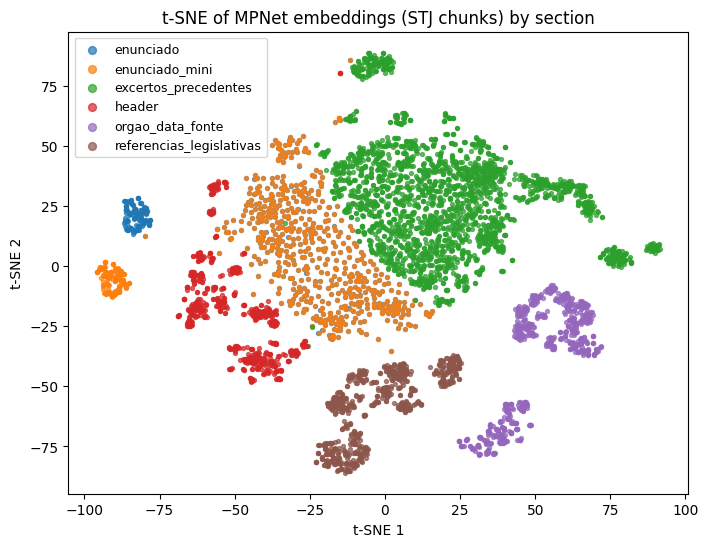

In [ ]:
df = pd.DataFrame({
    "id": ids,
    "number": numbers,
    "section": sections,
    "x": Y[:,0],
    "y": Y[:,1],
})
plt.figure(figsize=(8, 6))
unique_secs = sorted(set(sections))
for sec in unique_secs:
    mask = [s == sec for s in sections]
    plt.scatter(Y[mask, 0], Y[mask, 1], s=8, alpha=0.7, label=sec)
plt.title("t-SNE of MPNet embeddings (STJ chunks) by section")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(markerscale=2, fontsize=9, loc="best")
plt.show()

In [ ]:
import json, sys, subprocess, numpy as np
from pathlib import Path

try:
    import torch
    from sentence_transformers import SentenceTransformer
    from sklearn.neighbors import NearestNeighbors
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                           "torch", "sentence-transformers", "scikit-learn"])
    import torch
    from sentence_transformers import SentenceTransformer
    from sklearn.neighbors import NearestNeighbors


In [ ]:
CHUNKS_JSONL = "/content/sumulas_chunks_mpnet.jsonl"
MODEL_NAME   = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
MAX_SEQ_LEN  = 384
BATCH_SIZE   = 64
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
def load_chunks(path: str):
    return [json.loads(l) for l in open(path, "r", encoding="utf-8")]

In [ ]:
_model = None
def get_model():
    global _model
    if _model is None:
        _model = SentenceTransformer(MODEL_NAME, device=DEVICE)
        _model.max_seq_length = MAX_SEQ_LEN
    return _model

In [ ]:
def encode_texts(texts):
    m = get_model()
    try:
        embs = m.encode(texts, batch_size=BATCH_SIZE, convert_to_numpy=True,
                        normalize_embeddings=True, show_progress_bar=True).astype(np.float32)
    except TypeError:
        embs = m.encode(texts, batch_size=BATCH_SIZE, convert_to_numpy=True,
                        show_progress_bar=True).astype(np.float32)
        embs /= np.linalg.norm(embs, axis=1, keepdims=True).clip(min=1e-9)
    return embs

In [ ]:
chunks = load_chunks(CHUNKS_JSONL)

In [ ]:
index_chunks = [c for c in chunks if c["section"] not in ("enunciado", "enunciado_mini")]
ix_texts  = [c["text"] for c in index_chunks]
ix_ids    = [c["id"] for c in index_chunks]
ix_nums   = [c["number"] for c in index_chunks]

In [ ]:
print(f"Index docs: {len(index_chunks)} (sections={sorted(set(c['section'] for c in index_chunks))})")

In [ ]:
query_chunks = [c for c in chunks if c["section"] == "enunciado_mini"]
if not query_chunks:
    query_chunks = [c for c in chunks if c["section"] == "enunciado"]
q_texts = [c["text"] for c in query_chunks]
q_nums  = [c["number"] for c in query_chunks]
print(f"Queries: {len(q_texts)} (section = {query_chunks[0]['section'] if query_chunks else 'N/A'})")

In [ ]:
print("Encoding index…")
X = encode_texts(ix_texts)
print("Encoding queries…")
Q = encode_texts(q_texts)

In [ ]:
nn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(X)
dists, idxs = nn.kneighbors(Q, return_distance=True)

In [ ]:
def recall_at(k: int) -> float:
    hits = 0; eligible = 0
    for qi, target_num in enumerate(q_nums):
        if target_num not in ix_nums:
            continue
        eligible += 1
        retrieved_nums = {ix_nums[j] for j in idxs[qi, :k]}
        hits += int(target_num in retrieved_nums)
    return hits / max(1, eligible)

for k in [1, 3, 5, 10]:
    print(f"Recall@{k}: {recall_at(k):.3f}")

Index docs: 4412 (sections=['excertos_precedentes', 'header', 'orgao_data_fonte', 'referencias_legislativas'])
Queries: 676 (section = enunciado_mini)
Encoding index…


Batches:   0%|          | 0/69 [00:00<?, ?it/s]

Encoding queries…


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Recall@1: 0.327
Recall@3: 0.441
Recall@5: 0.490
Recall@10: 0.538


In [ ]:
import json, numpy as np, sys, subprocess
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
try:
    import torch
    from sentence_transformers import SentenceTransformer
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch", "sentence-transformers"])
    import torch
    from sentence_transformers import SentenceTransformer


In [ ]:
CHUNKS_JSONL = "/content/sumulas_chunks_mpnet.jsonl"
MODEL_NAME   = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
MAX_SEQ_LEN  = 384
BATCH_SIZE   = 64
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_chunks(path): return [json.loads(l) for l in open(path, "r", encoding="utf-8")]

In [ ]:
_model = None
def get_model():
    global _model;
    if _model is None:
        _model = SentenceTransformer(MODEL_NAME, device=DEVICE); _model.max_seq_length = MAX_SEQ_LEN
    return _model

def encode_texts(texts):
    m = get_model()
    X = m.encode(texts, batch_size=BATCH_SIZE, convert_to_numpy=True,
                 normalize_embeddings=True, show_progress_bar=True).astype(np.float32)
    return X

In [ ]:
chunks = load_chunks(CHUNKS_JSONL)
index_chunks = [c for c in chunks if c["section"] not in ("enunciado", "enunciado_mini")]
ix_texts  = [c["text"] for c in index_chunks]
ix_ids    = [c["id"] for c in index_chunks]
ix_nums   = [c["number"] for c in index_chunks]
ix_secs   = [c["section"] for c in index_chunks]

query_chunks = [c for c in chunks if c["section"] == "enunciado_mini"] or [c for c in chunks if c["section"] == "enunciado"]
q_texts = [c["text"] for c in query_chunks]
q_nums  = [c["number"] for c in query_chunks]

In [ ]:
print("Encoding index…")
X = encode_texts(ix_texts)
print("Encoding queries…")
Q = encode_texts(q_texts)

In [ ]:
TOP_CHUNKS = 50
nn = NearestNeighbors(n_neighbors=TOP_CHUNKS, metric="cosine").fit(X)
dists, idxs = nn.kneighbors(Q, return_distance=True)

In [ ]:
SECTION_WEIGHT = {"excertos_precedentes": 1.00, "referencias_legislativas": 1.05, "orgao_data_fonte": 0.95, "header": 0.90}

In [1]:
def recall_at_numbers(k: int) -> float:
    hits, eligible = 0, 0
    for qi, target in enumerate(q_nums):
        agg = defaultdict(float)
        for rank, j in enumerate(idxs[qi]):
            num = ix_nums[j]
            sec = ix_secs[j]
            w = SECTION_WEIGHT.get(sec, 1.0)
            score = (1.0 - float(dists[qi][rank])) * w
            agg[num] += score
        top_numbers = [n for n, _ in sorted(agg.items(), key=lambda x: x[1], reverse=True)[:k]]
        if target in set(ix_nums):
            eligible += 1
            if target in top_numbers:
                hits += 1
    return hits / max(1, eligible)

for k in [1,3,5,10]:
    print(f"Per-number Recall@{k}:", round(recall_at_numbers(k), 3))

Encoding index…


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

Encoding queries…


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Per-number Recall@1: 0.244
Per-number Recall@3: 0.382
Per-number Recall@5: 0.439
Per-number Recall@10: 0.558
